# ATIVIDADE 05/04/2025: POS-MDE-SEDU

## MODELOS DESCRITIVOS

### Professor: Sérgio Nery Simões

ATENÇÃO: ao final do notebook, há alguns exercícios de análise e interpretação de clusters. Leia o notebook com atenção procurando entender o que é realizado em cada passo e, ao final, procure resolver os exercícios.

# Análise Descritiva e Clusterização de Escolas por Evasão Escolar
Este notebook tem como objetivo realizar uma análise descritiva e aplicar técnicas de clusterização para identificar perfis de escolas com base na evasão escolar e características de infraestrutura.

## Importação de bibliotecas
Vamos importar as bibliotecas necessárias para manipulação de dados, visualizações e modelagem com K-means.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## Carregamento dos dados
Aqui carregamos o dataset simulado contendo informações sobre escolas, como localização, tipo de administração, infraestrutura e taxa de evasão.

In [2]:
df = pd.read_csv("../../datasets/evasao_escolar_simulado.csv")  # Substitua pelo caminho correto se necessário
print("Dimensão do dataset:", df.shape)
df.head()

Dimensão do dataset: (100, 10)


,id_escola,regiao,localizacao,dependencia_adm,infra_biblioteca,infra_internet,infra_laboratorio,total_matriculados,evasao_percentual,evasao_absoluta
0,1,Sul,Rural,Municipal,0,1,0,1183,12.007803,142
1,2,Centro-Oeste,Rural,Municipal,1,1,0,268,18.234745,48
2,3,Sudeste,Urbana,Estadual,0,1,0,745,17.397170,129
3,4,Centro-Oeste,Urbana,Municipal,1,1,1,252,19.930682,50
4,5,Centro-Oeste,Urbana,Municipal,1,0,1,404,2.384619,9


## Análise descritiva por região
Vamos calcular a média da evasão percentual por região para entender se há diferenças regionais.

In [3]:
print("Média de evasão percentual por região:")
print(df.groupby("regiao")["evasao_percentual"].mean().round(2))

Média de evasão percentual por região:
regiao
Centro-Oeste    10.64
Nordeste         9.61
Norte           12.61
Sudeste         11.47
Sul             12.08
Name: evasao_percentual, dtype: float64


Vamos calcular a média da evasão, entretanto, tomando os valores absolutos da evasão e o total de matrículas. Usar a média simples dos percentuais pode não representar corretamente a situação da evasão nas regiões, especialmente se o número de alunos por observação variar muito. O ideal é sempre ponderar para ter uma análise mais justa e fiel à realidade. Se as observações têm tamanhos diferentes (número de matrículas diferentes), a média simples dos percentuais pode distorcer o resultado.

Por exemplo: Uma escola com 10 alunos e 50% de evasão pesa igual a uma com 1000 alunos e 5% de evasão, na média simples. Isso pode inflar ou esconder a real média da evasão na região.

In [4]:
# Agrupa os dados por região somando os totais de evasão e de matrículas
agrupado = df.groupby("regiao")[["evasao_absoluta", "total_matriculados"]].sum()

# Calcula a taxa percentual de evasão por região de forma ponderada
agrupado["evasao_percentual_corrigida"] = (agrupado["evasao_absoluta"] / agrupado["total_matriculados"]) * 100

# Mostra o resultado final
print(agrupado["evasao_percentual_corrigida"].round(2))


regiao
Centro-Oeste     8.05
Nordeste         9.75
Norte           10.98
Sudeste         11.84
Sul             12.37
Name: evasao_percentual_corrigida, dtype: float64


In [5]:
agrupado.head()

,evasao_absoluta,total_matriculados,evasao_percentual_corrigida
regiao,,,
Centro-Oeste,1275,15833,8.052801
Nordeste,1519,15585,9.746551
Norte,1638,14921,10.977817
Sudeste,1191,10062,11.836613
Sul,2885,23318,12.372416


## Visualização da distribuição da evasão
Geramos um histograma para visualizar como a evasão percentual está distribuída entre as escolas.

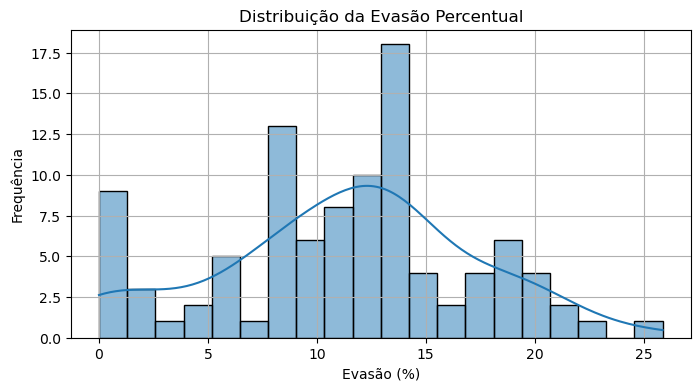

In [6]:
plt.figure(figsize=(8, 4))
sns.histplot(df['evasao_percentual'], bins=20, kde=True)
plt.title("Distribuição da Evasão Percentual")
plt.xlabel("Evasão (%)")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

## Codificação de variáveis categóricas
Transformamos variáveis categóricas em variáveis numéricas usando one-hot encoding, necessário para os algoritmos de clustering.

In [7]:
df_encoded = pd.get_dummies(df, columns=['regiao', 'localizacao', 'dependencia_adm'], drop_first=True)

In [8]:
df_encoded

,id_escola,infra_biblioteca,infra_internet,infra_laboratorio,total_matriculados,evasao_percentual,evasao_absoluta,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,localizacao_Urbana,dependencia_adm_Federal,dependencia_adm_Municipal
0,1,0,1,0,1183,12.007803,142,False,False,False,True,False,False,True
1,2,1,1,0,268,18.234745,48,False,False,False,False,False,False,True
2,3,0,1,0,745,17.397170,129,False,False,True,False,True,False,False
3,4,1,1,1,252,19.930682,50,False,False,False,False,True,False,True
4,5,1,0,1,404,2.384619,9,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,1,1,1,308,10.911203,33,False,False,True,False,True,False,False
96,97,0,1,1,1369,0.000000,0,False,False,False,False,False,False,True
97,98,1,0,0,310,8.072309,25,True,False,False,False,True,False,False
98,99,0,1,1,427,16.652193,71,True,False,False,False,True,False,False


### Observação
Por que criar colunas booleanas (0 e 1) ao invés de números inteiros (ex: 1 = Norte, 2 = Sul...)?

- One-hot encoding (o que foi feito)
  - Cria uma nova coluna para cada categoria e marca com 0 ou 1.
  - Não impõe nenhuma ordem entre as categorias.
  - Evita que o modelo interprete um valor como “maior” ou “menor” que o outro, o que acontece quando você usa números inteiros simples.
  - Funciona melhor com algoritmos baseados em distância, como K-Means.
- Label encoding, atribuindo um número a cada categoria, como 1=Norte, 2=Sul, etc.
  - É mais simples e ocupa menos espaço.
  - Mas introduz uma ordem artificial que não existe entre as regiões.
  - O modelo pode pensar que “região 2” é maior que “região 1”, o que não faz sentido.
- Quando usar um ou outro?
  - One-hot encoding: Categóricas sem ordem (ex: região, cor, sexo)
  - Label encoding: Categóricas com ordem natural (ex: nível de escolaridade, mês)
- K-Means (ou outro algoritmo de clusterização): K-Means calcula distâncias euclidianas. Se você codifica categorias como números inteiros (label encoding), ele vai achar que “Sudeste = 5” está mais longe de “Norte = 1” do que “Sul = 2” está de “Sudeste = 5”, o que é falso e pode afetar negativamente o agrupamento. Então, usar one-hot encoding está correto e é a melhor prática aqui.

## Seleção e normalização de variáveis
Selecionamos as variáveis mais relevantes para o agrupamento e aplicamos a padronização para evitar viés de escala.

In [9]:
features = [
    'infra_biblioteca', 'infra_internet', 'infra_laboratorio',
    'total_matriculados', 'evasao_percentual'
] + [col for col in df_encoded.columns if any(prefix in col for prefix in ['regiao_', 'localizacao_', 'dependencia_adm_'])]

X = df_encoded[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
X_scaled[0]

array([-1.12815215,  0.56195149, -0.96076892,  0.94122889,  0.12371553,
       -0.51558005, -0.46852129, -0.43643578,  1.68705478, -1.82970656,
       -0.31448545,  1.19959343])

In [11]:
[col for col in df_encoded.columns if any(prefix in col for prefix in ['regiao_', 'localizacao_', 'dependencia_adm_'])]

['regiao_Nordeste',
 'regiao_Norte',
 'regiao_Sudeste',
 'regiao_Sul',
 'localizacao_Urbana',
 'dependencia_adm_Federal',
 'dependencia_adm_Municipal']

Boa! Esse trecho é essencial para definir **quais variáveis vão ser usadas no modelo de clusterização**. Vamos destrinchar linha a linha 👇

---

### 🧠 Trecho de código:

```python
features = [
    'infra_biblioteca', 'infra_internet', 'infra_laboratorio',
    'total_matriculados', 'evasao_percentual'
] + [col for col in df_encoded.columns if any(prefix in col for prefix in ['regiao_', 'localizacao_', 'dependencia_adm_'])]
```

---

### 🔍 O que ele está fazendo?

#### 1. Primeiro, define uma **lista inicial fixa de colunas**:
```python
[
    'infra_biblioteca', 'infra_internet', 'infra_laboratorio',
    'total_matriculados', 'evasao_percentual'
]
```
Essas colunas representam:
- Três variáveis sobre infraestrutura escolar
- Total de alunos matriculados
- Taxa percentual de evasão

👉 Essas são variáveis numéricas diretamente relacionadas ao problema.

---

#### 2. Depois, ele **adiciona dinamicamente** outras colunas:
```python
[col for col in df_encoded.columns if any(prefix in col for prefix in ['regiao_', 'localizacao_', 'dependencia_adm_'])]
```

Isso é uma **compreensão de lista**, e o que ela faz é:
- Percorrer todas as colunas do `df_encoded`
- Selecionar apenas aquelas que **começam com os prefixos** `'regiao_'`, `'localizacao_'` ou `'dependencia_adm_'`
- Esses prefixos vêm do **one-hot encoding** feito nas variáveis categóricas

#### Exemplos de colunas incluídas:
- `regiao_Norte`, `regiao_Sul`, ...
- `localizacao_Urbana`, `localizacao_Rural`
- `dependencia_adm_Estadual`, `dependencia_adm_Municipal`, etc.

---

### ✅ Resultado final:

A variável `features` vira uma **lista completa de todas as colunas que serão usadas para fazer os agrupamentos (clusters)**, combinando:
- Variáveis numéricas diretas
- Variáveis categóricas transformadas em dummies (one-hot)

---

### 💡 Por que fazer isso assim?

- **Flexibilidade**: Se um novo valor de região aparecer nos dados, ele já será incluído automaticamente.
- **Organização**: Mantém o código mais limpo do que listar todas as colunas manualmente.

---

## Escolha do melhor número de clusters (k)
Testamos diferentes valores de k (de 2 a 9) e calculamos o coeficiente de silhouette para encontrar o número ótimo de clusters.

In [12]:
scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append((k, score))

# Exibe os resultados
for k, s in scores:
    print(f"Silhouette para k={k}: {s:.4f}")

best_k = max(scores, key=lambda x: x[1])[0]
print(f"\nMelhor número de clusters: {best_k}")

Silhouette para k=2: 0.0905
Silhouette para k=3: 0.1418
Silhouette para k=4: 0.1794
Silhouette para k=5: 0.1810
Silhouette para k=6: 0.1485
Silhouette para k=7: 0.1433
Silhouette para k=8: 0.1638
Silhouette para k=9: 0.1486

Melhor número de clusters: 5


## Aplicação do K-means com o melhor k
Executamos o algoritmo K-means com o número ideal de clusters encontrado anteriormente.

In [13]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

In [14]:
df.head()

,id_escola,regiao,localizacao,dependencia_adm,infra_biblioteca,infra_internet,infra_laboratorio,total_matriculados,evasao_percentual,evasao_absoluta,cluster
0,1,Sul,Rural,Municipal,0,1,0,1183,12.007803,142,0
1,2,Centro-Oeste,Rural,Municipal,1,1,0,268,18.234745,48,3
2,3,Sudeste,Urbana,Estadual,0,1,0,745,17.397170,129,2
3,4,Centro-Oeste,Urbana,Municipal,1,1,1,252,19.930682,50,0
4,5,Centro-Oeste,Urbana,Municipal,1,0,1,404,2.384619,9,4


É aqui, em `df['cluster']` que ele recupera a informação, mostrando em que cluster o procedimento classificou aquela "linha" foi classificada, e insere no dataframe original.

## Visualização dos clusters com PCA
Usamos PCA para reduzir a dimensionalidade dos dados e visualizar os grupos formados.

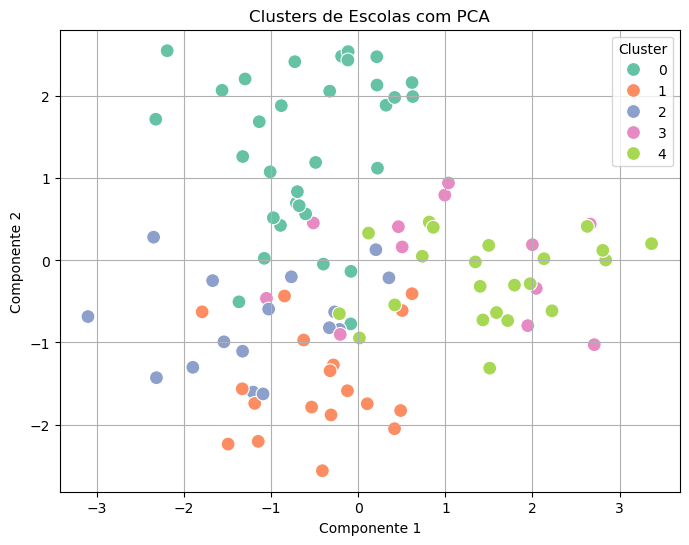

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
df['pca1'], df['pca2'] = components[:, 0], components[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='Set2', s=100)
plt.title('Clusters de Escolas com PCA')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

## Interpretação dos clusters
Por fim, analisamos a média das variáveis principais por grupo para interpretar os perfis encontrados.

In [ ]:
print("Médias por cluster:")
df.groupby('cluster')[['infra_biblioteca', 'infra_internet', 
                       'infra_laboratorio', 'total_matriculados', 
                       'evasao_percentual']].mean().round(2)

Médias por cluster:


,infra_biblioteca,infra_internet,infra_laboratorio,total_matriculados,evasao_percentual
cluster,,,,,
0,0.44,0.88,0.34,825.72,12.86
1,0.61,0.72,0.72,828.94,12.61
2,0.38,0.81,0.62,628.88,11.47
3,0.50,0.67,0.50,758.08,10.70
4,0.86,0.64,0.36,873.45,8.11



Distribuições para o Cluster 0:


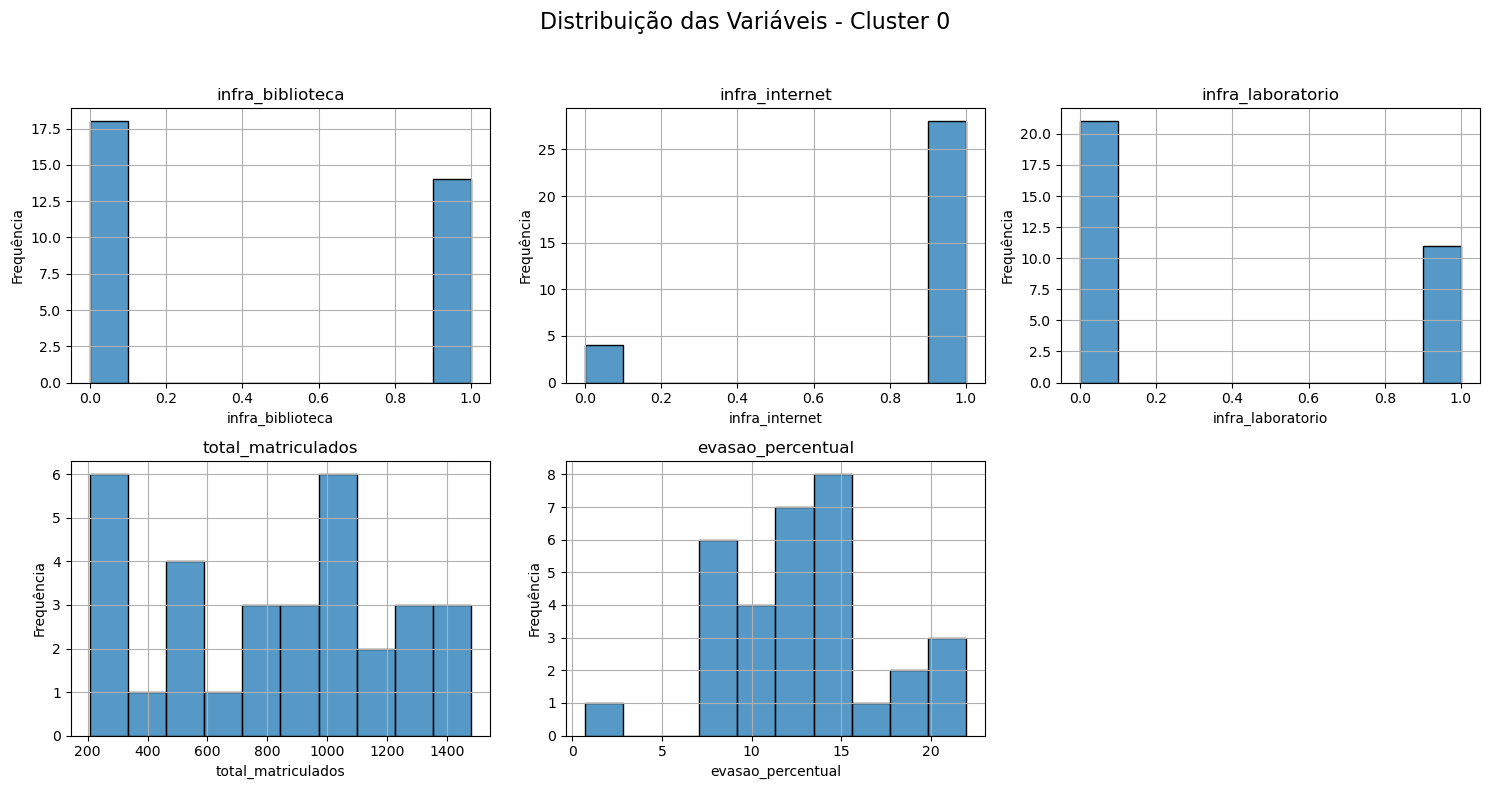


Distribuições para o Cluster 1:


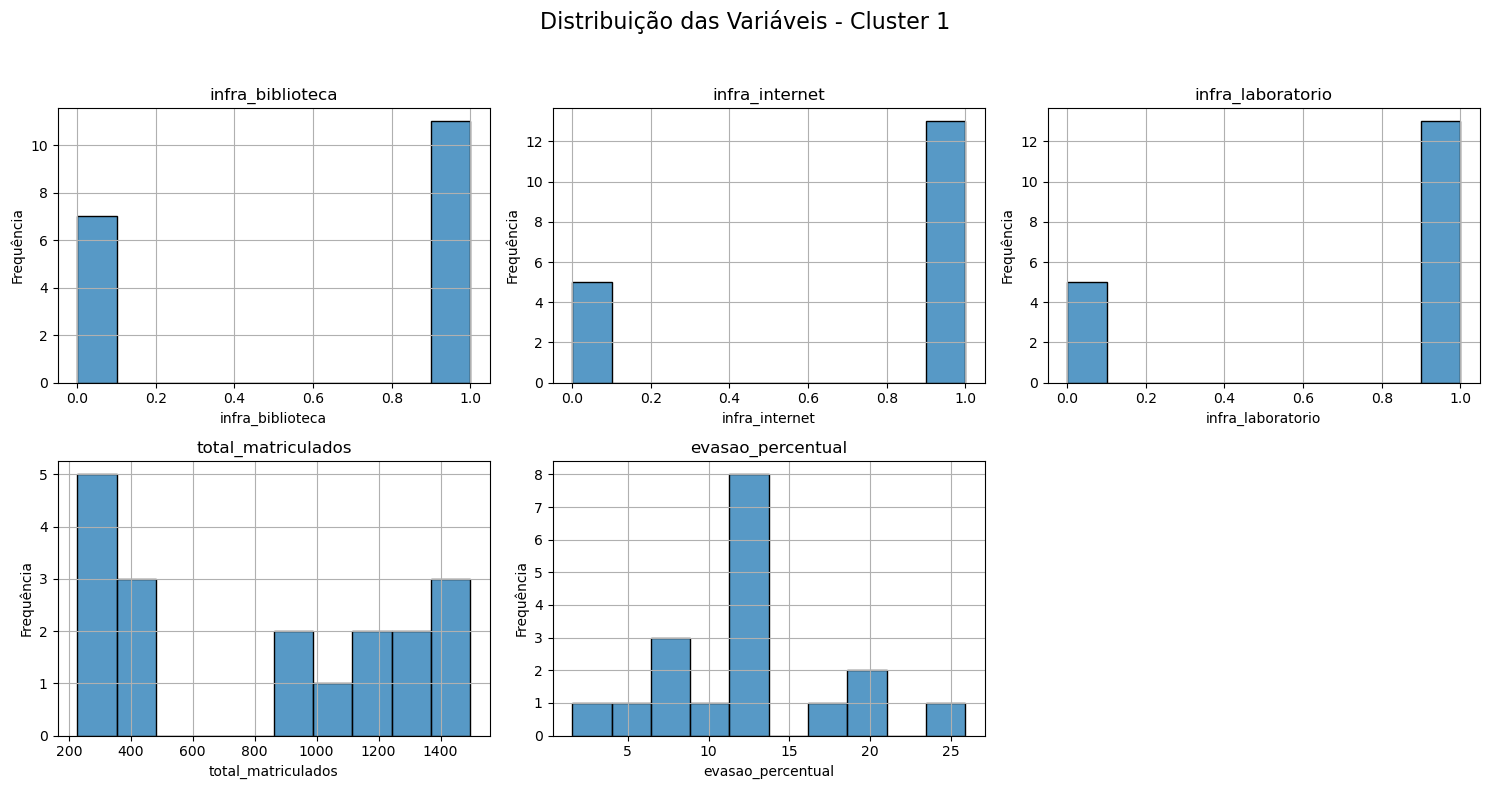


Distribuições para o Cluster 2:


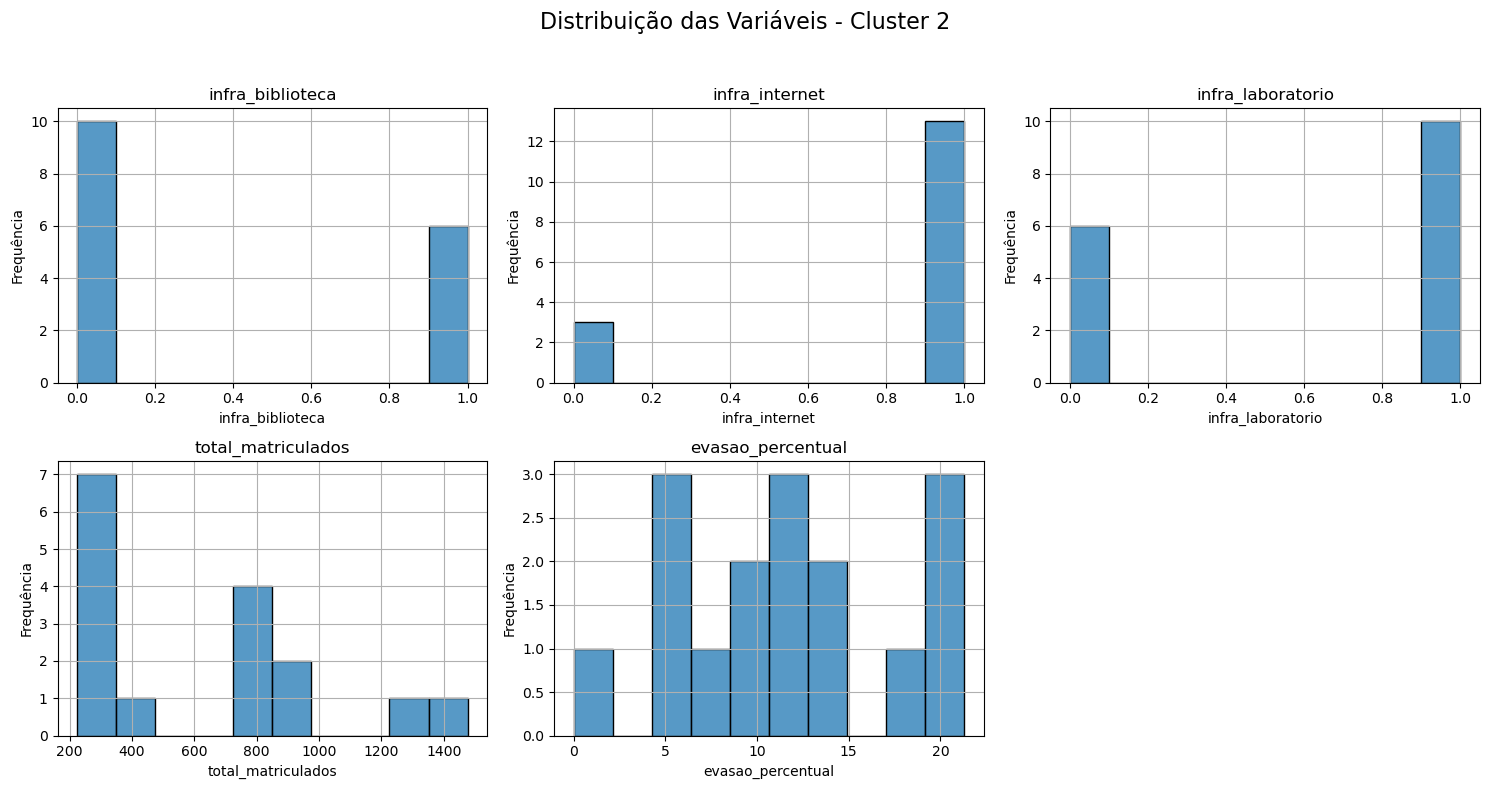


Distribuições para o Cluster 3:


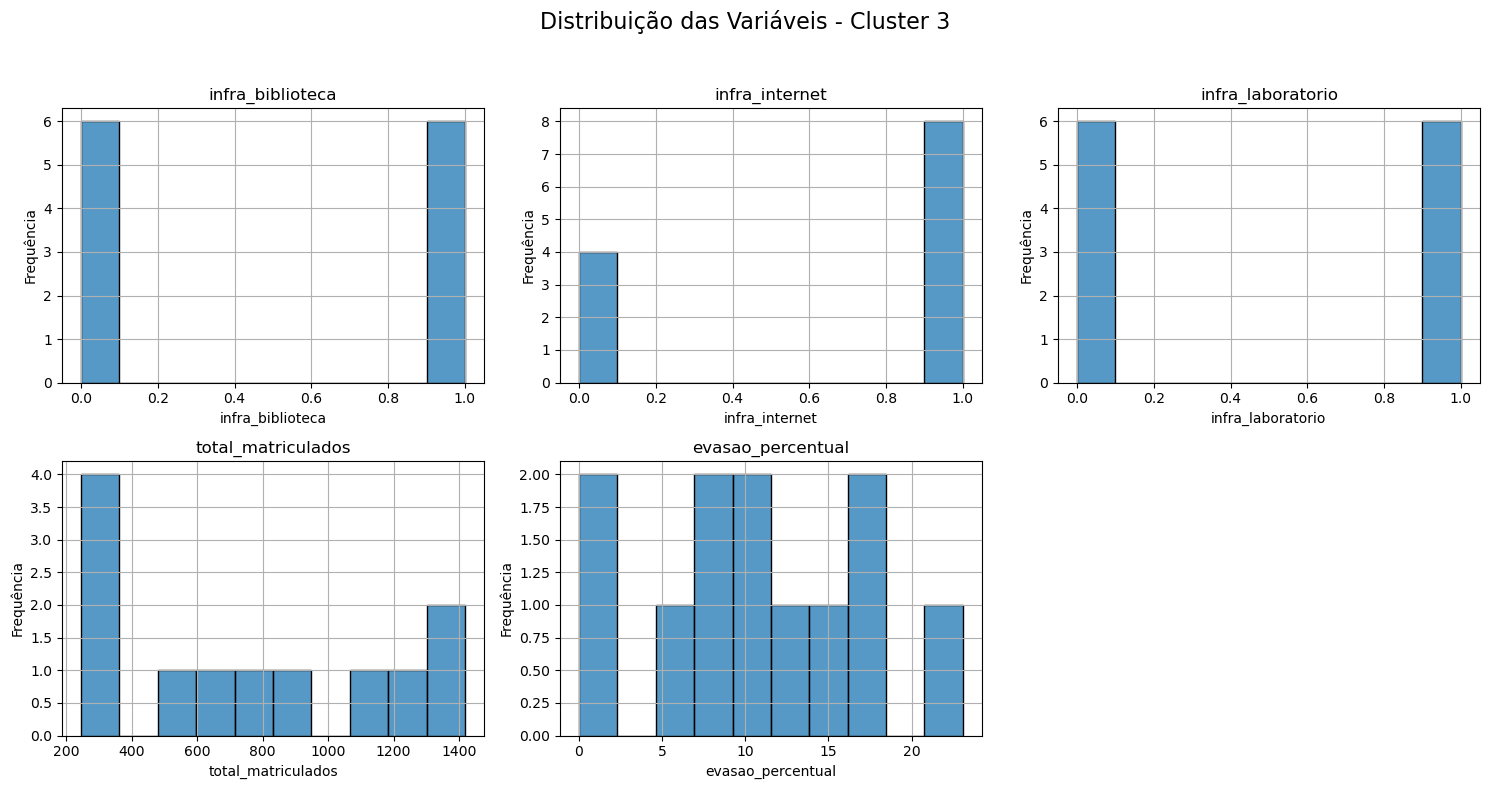


Distribuições para o Cluster 4:


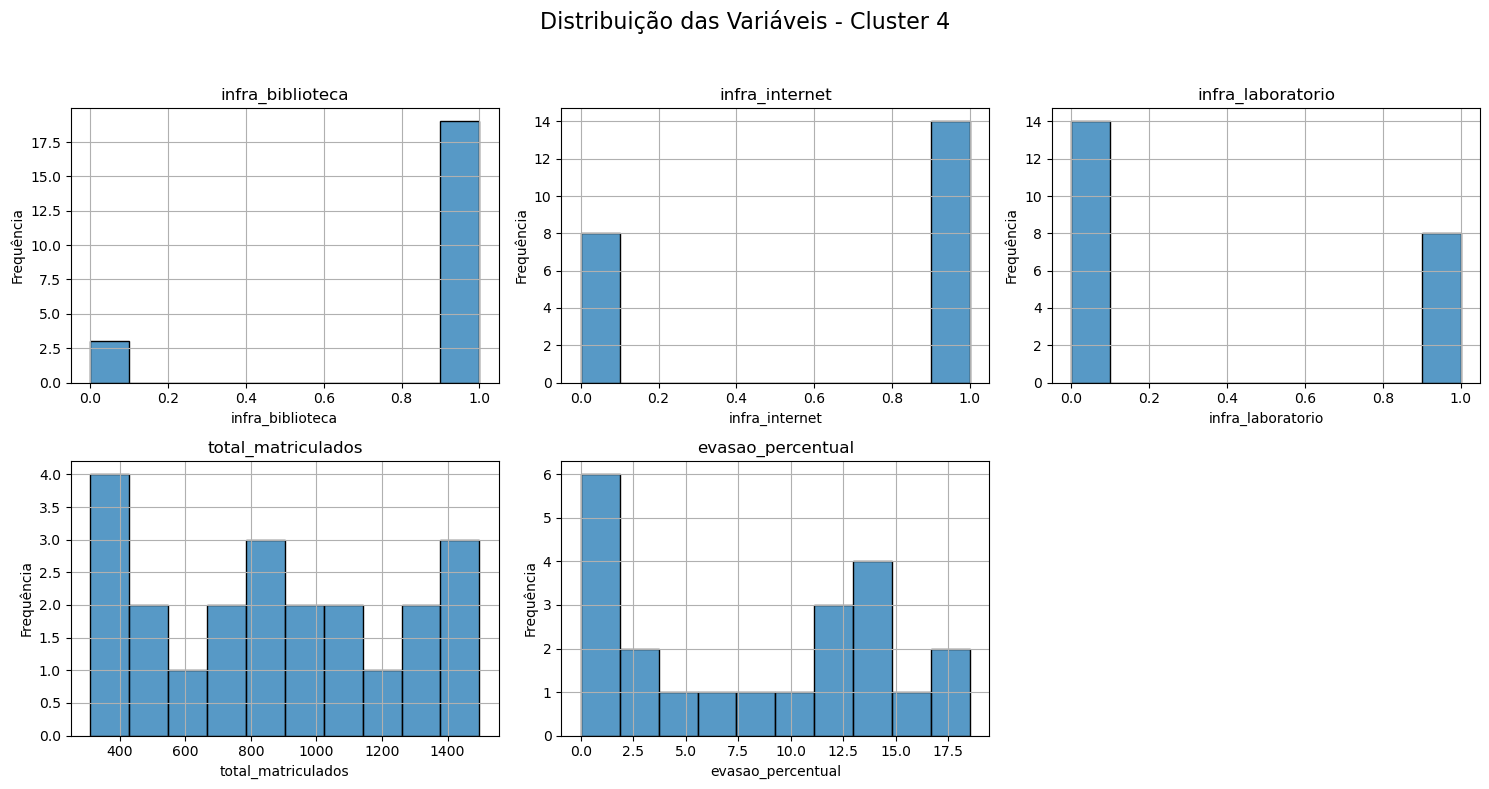

In [ ]:
# Visualização detalhada da distribuição para cada cluster com subplots 2x3
variables_to_plot = ['infra_biblioteca', 'infra_internet', 
                     'infra_laboratorio', 'total_matriculados', 
                     'evasao_percentual']

for cluster_id in sorted(df['cluster'].unique()):
    cluster_df = df[df['cluster'] == cluster_id]
    print(f"\nDistribuições para o Cluster {cluster_id}:")
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    for i, var in enumerate(variables_to_plot):
        sns.histplot(cluster_df[var], bins=10, kde=False, ax=axes[i])
        axes[i].set_title(f'{var}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Frequência')
        axes[i].grid(True)
    for j in range(len(variables_to_plot), len(axes)):
        fig.delaxes(axes[j])  # Remove subplot vazio se houver
    fig.suptitle(f'Distribuição das Variáveis - Cluster {cluster_id}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Perguntas para Análise e Interpretação dos Clusters

### 🧪 Análise Técnica dos Clusters

1. Quais variáveis mais se destacam em cada cluster? (ex: evasão, infraestrutura, número de alunos)
2. Há variáveis que variam pouco entre os clusters? O que isso indica?
3. Em qual cluster estão concentradas as escolas com maior evasão?
4. Qual cluster apresenta maior variabilidade interna? O que isso pode significar?
5. As distribuições das variáveis são simétricas ou assimétricas dentro dos clusters?
6. Existe algum padrão geográfico (ex: região, zona urbana/rural) associado a cada cluster?
7. Alguma infraestrutura aparece de forma consistente nos clusters com menor evasão?

**RESPOSTAS:**  
    ...  
    ...  
    ...  
    ...  
    ...  
    ...  


### 📊 Análise Gerencial e Tomada de Decisão

8. Se você tivesse recursos limitados, qual cluster você priorizaria para intervenção imediata? Por quê?
9. Que tipo de ação (pedagógica, tecnológica, estrutural) seria mais adequada para o cluster com maior evasão?
10. O cluster com boas condições e baixa evasão pode servir de modelo? O que ele pode ensinar aos demais?
11. Que critérios objetivos você usaria para priorizar escolas dentro de um mesmo cluster?
12. Como os perfis encontrados poderiam orientar o planejamento de políticas públicas ou programas regionais?

**RESPOSTAS:**  
    ...  
    ...  
    ...  
    ...  
    ...  
    ...  


---
**Desafio Final (Reflexão):**
Se você fosse apresentar esses resultados à equipe gestora da Secretaria da Educação, que 3 recomendações faria com base nos clusters encontrados?

.  
.  
.  
.  
.  

---

**Bom trabalho!**